# Neural SVGD

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
    
key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [29]:
%autoreload

# 50-Dimensional Gaussian with different variance scales

In [30]:
d = 50
variances = np.logspace(-2, 0, num=d)
target = distributions.Gaussian(np.zeros(d), variances)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [32]:
n_steps = 3500
particle_lr = 1e-2
learner_lr = 1e-2
n_particles = 1000
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., sizes=[32, 32, d], patience=0, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=100,         n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 3500/3500 [00:28<00:00, 121.47it/s]


In [34]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

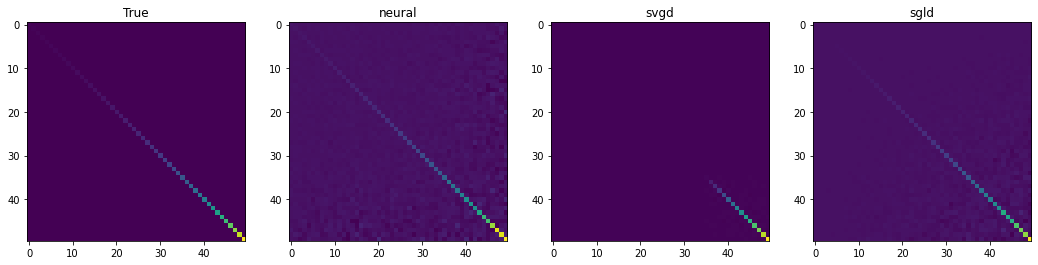

In [35]:
fig, axs = plt.subplots(1, 4, figsize=[18, 5])
axs = axs.flatten()
for ax, cov, title in zip(axs, covs, titles):
    ax.imshow(cov)
    ax.set_title(title)

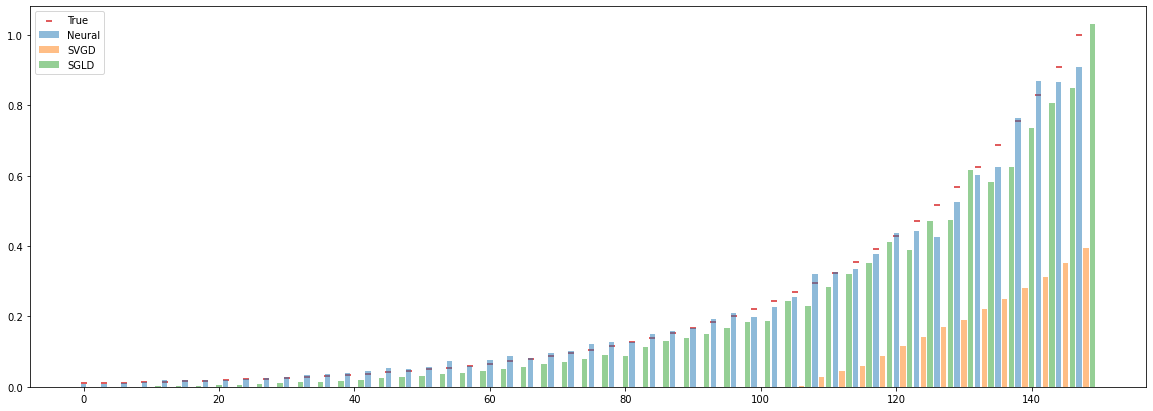

In [36]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
num=3
grid = np.arange(0, d*num, step=num)

for cov_diagonal, name, i in zip([np.diag(cov) for cov in covs[1:]], ["Neural", "SVGD", "SGLD"], range(3)):
    plt.bar(grid+i, cov_diagonal, alpha=0.5, label=name)

plt.scatter(grid, np.diag(target.cov), marker="_", label="True")
plt.legend()
# plt.yscale("log")

In [39]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=[10, 8])
# # plt.ylim((0, 5))
# stdneur = np.array(neural_particles.rundata["training_std"])
# # stdsvgd = svgd_particles.rundata["training_std"]
# # stdsgld = sgld_particles.rundata["training_std"]


# # plt.plot(onp.mean(neural_particles.rundata["validation_std"], axis=1), color="blue", label="Neural Score Matching: Validation particles")
# plt.plot(stdneur, color="tab:blue", label="Neural SVGD")
# # plt.plot(stdsvgd, color="tab:orange", label="SVGD")
# # plt.plot(stdsgld, color="tab:green", label="SGLD")

# [plt.axhline(y=y, color="black", linestyle="--") for y in np.sqrt(variances)]

# plt.ylabel("Standard Deviation")
# plt.xlabel("Step")

# plt.legend()
# plt.yscale("log")

In [154]:
neural_trajectory = np.array(neural_particles.rundata["particles"])
slice_idx = [0, 1]
neural_trajectory_sliced = neural_trajectory[:, :, slice_idx]
sliced_target = distributions.Gaussian([0, 0], variances[slice_idx])

# %matplotlib widget
# fig, ax = plt.subplots(figsize=[10, 10])
# lim=(-11, 11)
# ax.set(xlim=lim, ylim=lim)

# # plot.plot_fun_2d(sliced_target.pdf, lims=lim, ax=ax, alpha=0.5)
# plot.animate_array(neural_trajectory_sliced, fig, ax, interval=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# High-dim mixture

In [40]:
# sample m points from the corners of d-simplex
d = 3
m = 3 # =< d
idx = random.choice(key, d, (m,), replace=False)
means = np.eye(d)[idx] * 5

target = distributions.GaussianMixture(means, 1, np.ones(m))
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [47]:
%autoreload

In [48]:
n_steps = 500
noise = 0.
particle_lr = 1e-2
learner_lr = 1e-2
n_particles = 1000
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=noise, sizes=[32, 32, d], patience=0, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=100, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 500/500 [00:01<00:00, 418.19it/s]


In [50]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

true_samples = target.sample(1000)

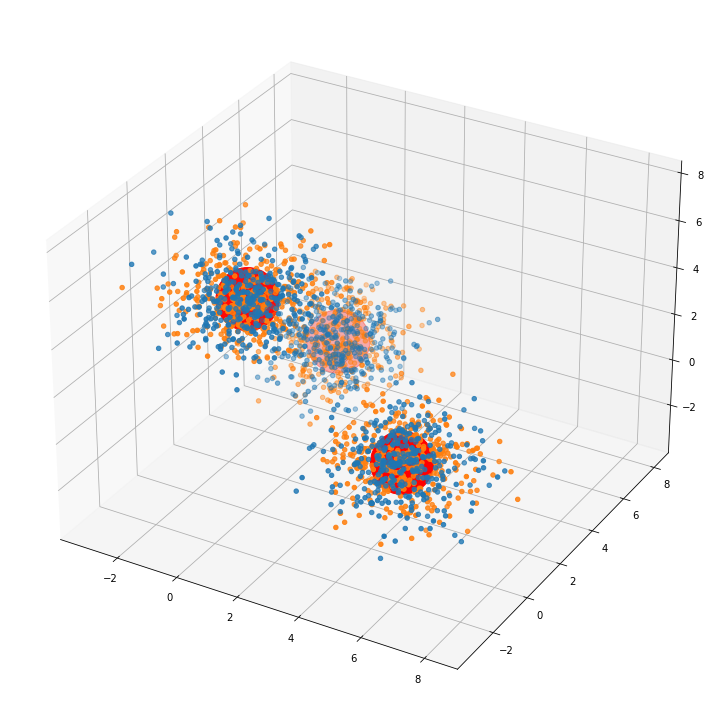

In [51]:
%matplotlib inline
fig = plt.figure(figsize=[13, 13])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*np.rollaxis(neural_final, 1))
ax.scatter(*np.rollaxis(sgld_final, 1))
ax.scatter(*np.rollaxis(target.means, 1), s=4000, color="red")

## Rundata high dim mixture

#### trajectory

In [52]:
neural_trajectory = np.array(neural_particles.rundata["particles"])
sgld_trajectory = np.array(sgld_particles.rundata["particles"])

neural_trajectory_sliced = neural_trajectory[:, :200, slice_idx]

TypeError: Unexpected input type for array: <class 'models.SplitData'>

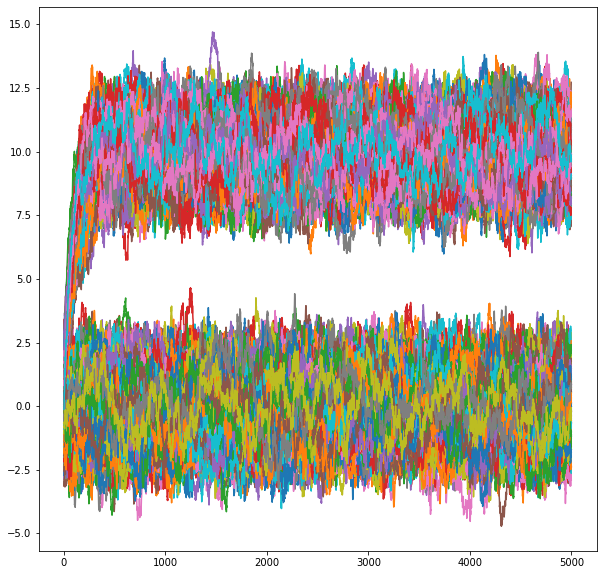

In [79]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[10, 10])
_ = plt.plot(sgld_trajectory[:, :, 0])

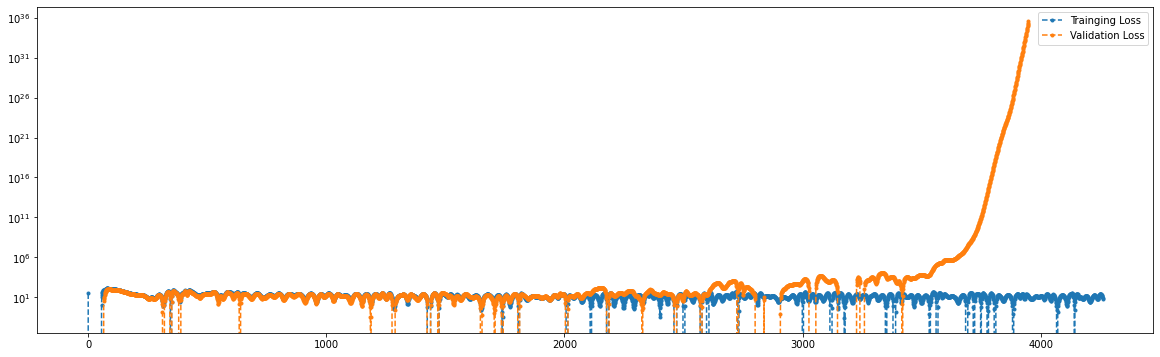

In [52]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_loss"], "--.", label="Validation Loss")
# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(0., 1e35)
plt.legend()
plt.yscale("log")

# OLD

In [10]:
# fig, axs = plt.subplots(1, 4, figsize=[18, 5])
# axs = axs.flatten()
# for ax, cov, title in zip(axs, covs, titles):
#     ax.imshow(undo_rot(cov))
#     ax.set_title(title)

NameError: name 'undo_rot' is not defined

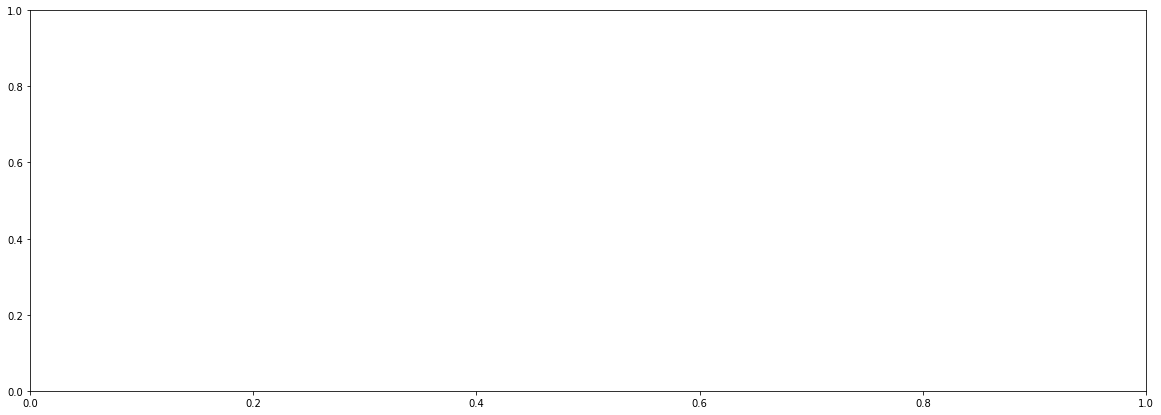

In [11]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
num=3
grid = np.arange(0, d*num, step=num)

for cov_diagonal, name, i in zip([np.diag(undo_rot(cov)) for cov in covs[1:]], ["Neural", "SVGD", "SGLD"], range(3)):
    plt.bar(grid+i, cov_diagonal, alpha=0.5, label=name)

plt.scatter(grid, np.diag(undo_rot(target.cov)), marker="_", label="True")
plt.legend()
plt.yscale("log")

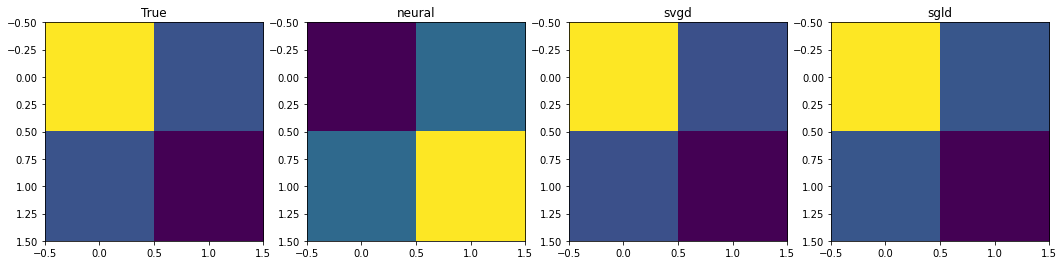

In [27]:
fig, axs = plt.subplots(1, 4, figsize=[18, 5])
axs = axs.flatten()
for ax, cov, title in zip(axs, covs, titles):
    ax.imshow(cov)
    ax.set_title(title)

In [114]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=[15, 25])
# # plt.ylim((0, 5))
# stdneur = np.array(neural_particles.rundata["training_std"])
# # stdsvgd = svgd_particles.rundata["training_std"]
# # stdsgld = sgld_particles.rundata["training_std"]


# # plt.plot(onp.mean(neural_particles.rundata["validation_std"], axis=1), color="blue", label="Neural Score Matching: Validation particles")
# plt.plot(stdneur, color="tab:blue", label="Neural Score Matching")
# # plt.plot(stdsvgd, color="tab:orange", label="SVGD")
# # plt.plot(stdsgld, color="tab:green", label="SGLD")

# [plt.axhline(y=y, color="black", linestyle="--") for y in np.sqrt(variances)]

# plt.ylabel("Standard Deviation")
# plt.xlabel("Step")

# plt.legend()
# # plt.yscale("log")

## plot learned gradient (projection)

In [12]:
slice_idx = [0, 9]

In [13]:
particles, _ = neural_particles.get_params(split_by_group=True)
# _, particles = neural_particles.get_params(split_by_group=True)
# x0 = particles[0]
x0 = np.zeros(d)

def sliced_grads(xs):
    """function (n, 2) to (n, 2)"""
    n = len(xs)
    x0s = np.tile(x0, (n, 1)) # shape (n, d)
    xs_nd = index_update(x0s, index[:, slice_idx], xs)
    vec_nd = neural_learner.grads(xs_nd)
    return vec_nd[:, slice_idx]

sliced_target = distributions.Gaussian([0, 0], variances[slice_idx])
approx_q = distributions.Gaussian(np.mean(particles, axis=0)[slice_idx], np.var(particles, axis=0)[slice_idx])
sliced_grads_true = vmap(grad(lambda x: sliced_target.logpdf(x) - approx_q.logpdf(x)))

sliced_particles = particles[:, slice_idx] 

NameError: name 'variances' is not defined

NameError: name 'sliced_grads_true' is not defined

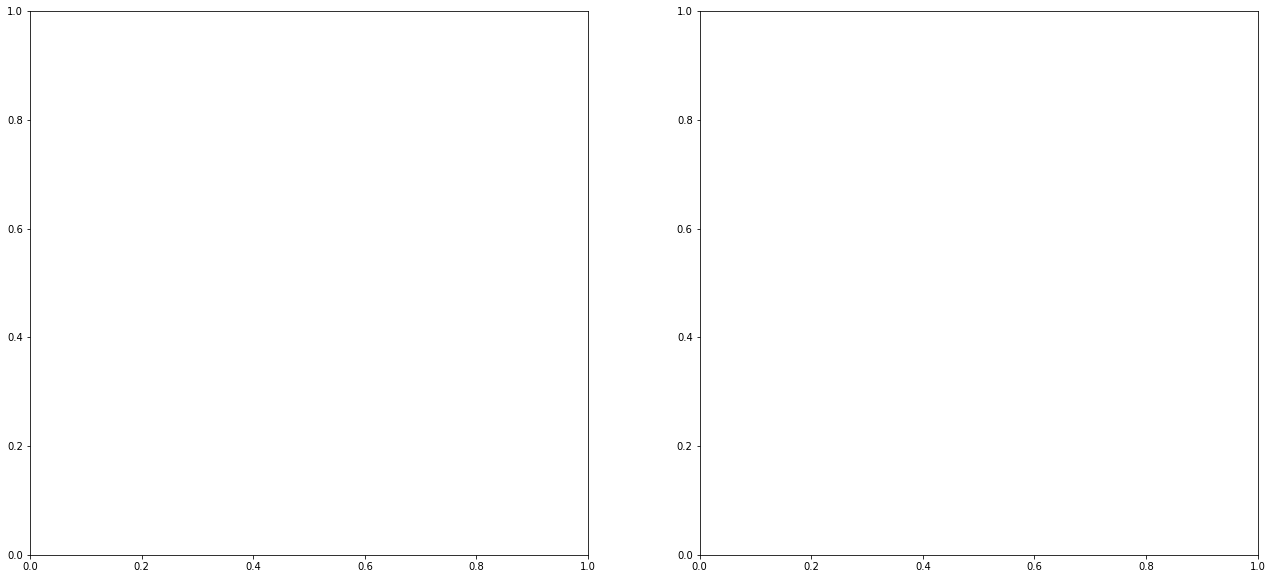

In [14]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=[22, 10])
axs = axs.flatten()
# lims=(-1/4, 1/4)
lims=(-11, 11)
# lims = utils.get_particle_lims(particles[:, slice_idx])
true_samples = target.sample(1000)
for ax, grad_fn in zip(axs, [sliced_grads, sliced_grads_true]):
    ax.set(xlim=lims, ylim=lims)
#     plot.plot_fun_2d(sliced_target.pdf, lims=lims, ax=ax, alpha=0.5)
    plot.plot_gradient_field(grad_fn, ax, lims=lims)
    plot.scatter(sliced_particles, ax=ax)
    plot.scatter(true_samples[:, slice_idx], ax=ax)

# animation

In [123]:
%matplotlib inline
# fig, ax = plt.subplots(figsize=[10, 10])
# _ = plt.plot(neural_trajectory[:, :, 9])

In [58]:
neural_trajectory_sliced.shape

(100, 200, 2)

In [59]:
np.var(neural_trajectory[800], axis=0)[slice_idx]

DeviceArray([6463.377 , 1819.4465], dtype=float32)

In [154]:
%matplotlib widget
fig, ax = plt.subplots(figsize=[10, 10])
lim=(-11, 11)
# lim=utils.get_particle_lims(sliced_particles)
ax.set(xlim=lim, ylim=lim)
# plot.plot_fun_2d(sliced_target.pdf, lims=lim, ax=ax, alpha=0.5)
plot.animate_array(neural_trajectory_sliced, fig, ax, interval=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Loss

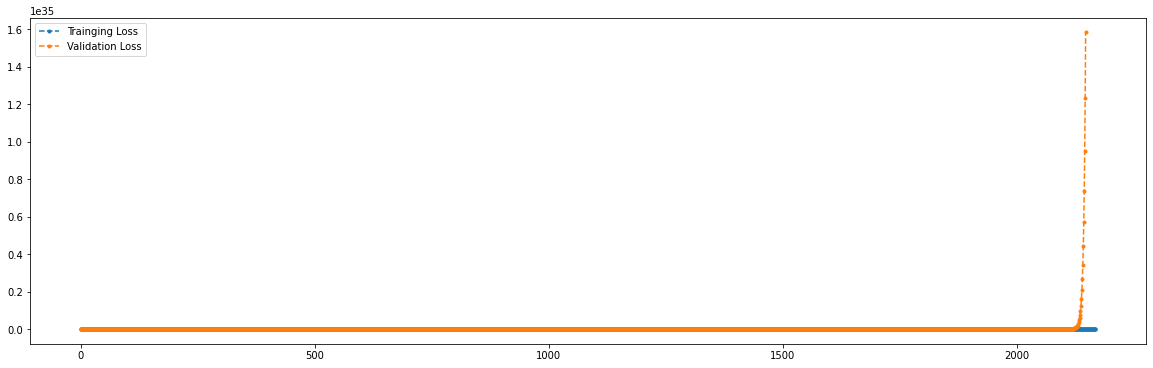

In [69]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_loss"], "--.", label="Validation Loss")
# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(-100, 100)
plt.legend()

## metrics

In [110]:
psvgd, *_ = svgd_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(psvgd, target)

{'emd': DeviceArray(2.7817569, dtype=float32),
 'ksd': DeviceArray(5.404147, dtype=float32),
 'se_mean': DeviceArray(0.00044847, dtype=float32),
 'se_std': DeviceArray(0.04542517, dtype=float32)}

In [112]:
p, *_ = neural_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p[:100], target)

{'emd': DeviceArray(3.7362332, dtype=float32),
 'ksd': DeviceArray(0.0062103, dtype=float32),
 'se_mean': DeviceArray(0.00179533, dtype=float32),
 'se_std': DeviceArray(0.00616832, dtype=float32)}

In [113]:
p, *_ = sgld_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p[:100], target)

{'emd': DeviceArray(3.436739, dtype=float32),
 'ksd': DeviceArray(0.00637997, dtype=float32),
 'se_mean': DeviceArray(0.00175899, dtype=float32),
 'se_std': DeviceArray(0.00098737, dtype=float32)}

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7ff548b9a910>>
Traceback (most recent call last):
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tornado/ioloop.py", line 907, in _run
    return self.callback()
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1194, in _on_timer
    ret = func(*args, **kwargs)
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/animation.py", line 1424, in _step
    self.event_source.interval = self._repeat_delay
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1135, in interval
    self._timer_set_interval()
  File "/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/matplotlib/backends/backend_webagg_core.py", line 537, in _timer_set_interval
    self._timer_start()
  Fi